# 🧬 Conway's Game of Life: Analysis & Benchmarking

This notebook provides a comprehensive analysis of Conway's Game of Life, featuring:
1. **Visualization**: A pure Python implementation to demonstrate the rules visually.
2. **Integration**: Wrappers to compile and run the optimized C implementations (Sequential & Pthreads).
3. **Benchmarking**: Automated performance testing to measure speedup and memory usage.

In [2]:
import os
import sys
import re
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# --- WORKING DIRECTORY SETUP ---
# Since this notebook is in 'tools/', we need to move up to the project root
# to access the Makefile, src/, and bin/ directories correctly.
if os.path.basename(os.getcwd()) == 'tools':
    os.chdir('..')
    print(f"Moved working directory to project root: {os.getcwd()}")
else:
    print(f"Current working directory: {os.getcwd()}")

# Define paths
BIN_DIR = "bin"
SAMPLES_DIR = "samples"
SEQ_EXE = os.path.join(BIN_DIR, "game_of_life_seq")
PAR_EXE = os.path.join(BIN_DIR, "game_of_life_pthread")

# Ensure samples directory exists
os.makedirs(SAMPLES_DIR, exist_ok=True)

Moved working directory to project root: /home/fc/Documents/github/parallel-computing/project-2-game-of-life-pthreads


## 1️⃣ Part 1: Logic Visualization (Pure Python)

Before running the high-performance C code, we implement the logic in Python to visualize how the cellular automaton evolves.

**Rules:**
1. **Underpopulation**: A live cell with < 2 neighbors dies.
2. **Survival**: A live cell with 2 or 3 neighbors lives.
3. **Overpopulation**: A live cell with > 3 neighbors dies.
4. **Reproduction**: A dead cell with exactly 3 neighbors becomes a live cell.

In [3]:
def python_step(grid):
    """
    Pure Python/NumPy implementation of one Game of Life step.
    Uses circular boundary conditions (toroidal) via np.roll for simplicity in viz.
    """
    # Calculate neighbors using 8 shifts
    neighbors = (
        np.roll(grid, 1, 0) + np.roll(grid, -1, 0) +
        np.roll(grid, 1, 1) + np.roll(grid, -1, 1) +
        np.roll(np.roll(grid, 1, 0), 1, 1) +
        np.roll(np.roll(grid, 1, 0), -1, 1) +
        np.roll(np.roll(grid, -1, 0), 1, 1) +
        np.roll(np.roll(grid, -1, 0), -1, 1)
    )
    
    new_grid = np.zeros_like(grid)
    # Apply rules
    new_grid[(grid == 1) & ((neighbors == 2) | (neighbors == 3))] = 1
    new_grid[(grid == 0) & (neighbors == 3)] = 1
    
    return new_grid

def create_pattern(rows=50, cols=50):
    """Creates a grid with a Gosper Glider Gun."""
    grid = np.zeros((rows, cols), dtype=int)
    gun_coords = [
        (5,1),(5,2),(6,1),(6,2),
        (3,13),(3,14),(4,12),(4,16),(5,11),(5,17),(6,11),(6,15),(6,17),(6,18),
        (7,11),(7,17),(8,12),(8,16),(9,13),(9,14),
        (1,25),(2,23),(2,25),(3,21),(3,22),(4,21),(4,22),(5,21),(5,22),
        (6,23),(6,25),(7,25),
        (3,35),(3,36),(4,35),(4,36)
    ]
    for r, c in gun_coords:
        if r < rows and c < cols:
            grid[r, c] = 1
    return grid

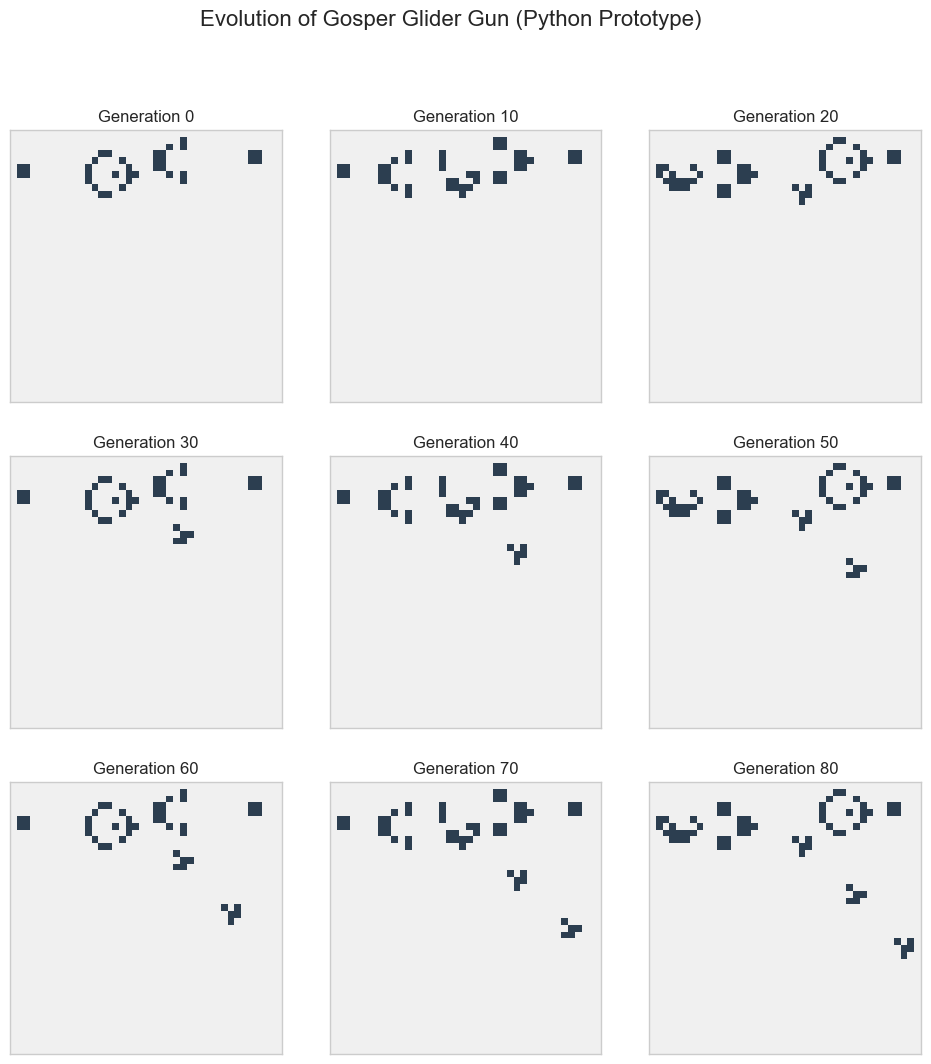

In [4]:
# Run Visualization
rows, cols = 40, 40
grid = create_pattern(rows, cols)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

cmap = ListedColormap(['#f0f0f0', '#2c3e50'])

current_grid = grid.copy()

for i, ax in enumerate(axes):
    ax.imshow(current_grid, cmap=cmap, interpolation='nearest')
    ax.set_title(f"Generation {i*10}")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Advance 10 generations for the next frame
    for _ in range(10):
        current_grid = python_step(current_grid)

plt.suptitle("Evolution of Gosper Glider Gun (Python Prototype)", fontsize=16)
plt.show()

## 2️⃣ Part 2: C Compilation & Integration

We will now compile the project using the `Makefile` in the root directory. This ensures we are testing the latest version of the C code.

In [5]:
print("🔨 Compiling C project...")

try:
    # Clean previous builds
    subprocess.run(["make", "clean"], check=True, stdout=subprocess.DEVNULL)
    
    # Build sequential
    subprocess.run(["make", "sequential"], check=True, stdout=subprocess.PIPE)
    print("✅ Sequential build successful.")
    
    # Build parallel
    subprocess.run(["make", "parallel"], check=True, stdout=subprocess.PIPE)
    print("✅ Parallel build successful.")
    
except subprocess.CalledProcessError as e:
    print(f"❌ Compilation failed: {e}")

if not (os.path.exists(SEQ_EXE) and os.path.exists(PAR_EXE)):
    print("⚠️ Warning: Binaries not found!")

🔨 Compiling C project...
✅ Sequential build successful.
✅ Parallel build successful.


In [6]:
def parse_c_output(stdout_str):
    """
    Parses stdout from the C programs to extract Time and Peak Memory.
    Example output: 
      [Sequential] Execution time: 0.123456 seconds
      [Sequential] Peak memory: 1234 KB
    """
    time_match = re.search(r"Execution time:\s+([0-9\.]+)\s+seconds", stdout_str)
    mem_match = re.search(r"Peak memory:\s+([0-9]+)\s+KB", stdout_str)
    
    exec_time = float(time_match.group(1)) if time_match else None
    peak_mem = int(mem_match.group(1)) if mem_match else None
    
    return exec_time, peak_mem

def generate_input_file(filename, rows, cols, generations, density=0.2):
    """
    Generates a random input file compatible with the C loader.
    """
    filepath = os.path.join(SAMPLES_DIR, filename)
    total_cells = rows * cols
    alive_cells = int(total_cells * density)
    
    # Fast random generation
    rng = np.random.default_rng()
    flat_indices = rng.choice(total_cells, alive_cells, replace=False)
    rows_idx, cols_idx = np.unravel_index(flat_indices, (rows, cols))
    
    with open(filepath, 'w') as f:
        f.write(f"{generations}\n")
        f.write(f"{rows} {cols}\n")
        f.write(f"{alive_cells}\n")
        for r, c in zip(rows_idx, cols_idx):
            f.write(f"{r} {c}\n")
            
    return filepath

def run_benchmark(executable, input_file, threads=None):
    cmd = [executable, input_file]
    if threads:
        cmd.append(str(threads))
        
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
        time_sec, mem_kb = parse_c_output(result.stdout)
        return time_sec, mem_kb
    except subprocess.CalledProcessError as e:
        print(f"Error running {executable}: {e.stderr}")
        return None, None

## 3️⃣ Part 3: Benchmarking

We will now run a comprehensive benchmark suite:
1. **Scaling**: Increasing grid size (N x N).
2. **Threading**: Increasing thread counts (1, 2, 4, 8).
3. **Metrics**: Measuring Execution Time and Peak RSS Memory.

In [7]:
# Benchmark Configuration
GRID_SIZES = [1000, 2000, 4000, 5000]
THREAD_COUNTS = [1, 2, 4, 8]
GENERATIONS = 50
DENSITY = 0.2

results = []

print(f"🚀 Starting Benchmark (Generations: {GENERATIONS})...")
print(f"{'Size':<10} | {'Type':<10} | {'Threads':<8} | {'Time (s)':<10} | {'Mem (MB)':<10}")
print("-" * 65)

for size in GRID_SIZES:
    # Generate input for this size
    filename = f"bench_{size}x{size}.txt"
    input_path = generate_input_file(filename, size, size, GENERATIONS, DENSITY)
    
    # 1. Run Sequential
    seq_time, seq_mem = run_benchmark(SEQ_EXE, input_path)
    
    if seq_time is not None:
        mem_mb = seq_mem / 1024
        print(f"{size:<10} | {'Seq':<10} | {'1':<8} | {seq_time:<10.4f} | {mem_mb:<10.1f}")
        results.append({
            "Size": size,
            "Type": "Sequential",
            "Threads": 1,
            "Time": seq_time,
            "Memory_MB": mem_mb,
            "Speedup": 1.0
        })
    
    # 2. Run Parallel with varying threads
    for t in THREAD_COUNTS:
        par_time, par_mem = run_benchmark(PAR_EXE, input_path, threads=t)
        
        if par_time is not None:
            speedup = seq_time / par_time if seq_time else 0
            mem_mb = par_mem / 1024
            print(f"{size:<10} | {'Par':<10} | {t:<8} | {par_time:<10.4f} | {mem_mb:<10.1f}")
            results.append({
                "Size": size,
                "Type": "Parallel",
                "Threads": t,
                "Time": par_time,
                "Memory_MB": mem_mb,
                "Speedup": speedup
            })

# Create DataFrame
df = pd.DataFrame(results)

🚀 Starting Benchmark (Generations: 50)...
Size       | Type       | Threads  | Time (s)   | Mem (MB)  
-----------------------------------------------------------------
1000       | Seq        | 1        | 4.4958     | 149.5     
1000       | Par        | 1        | 4.6492     | 149.5     
1000       | Par        | 2        | 2.3792     | 149.5     
1000       | Par        | 4        | 1.2800     | 149.5     
1000       | Par        | 8        | 0.7530     | 149.5     
2000       | Seq        | 1        | 18.0787    | 176.6     
2000       | Par        | 1        | 17.4321    | 176.6     
2000       | Par        | 2        | 8.8742     | 176.6     
2000       | Par        | 4        | 4.7588     | 176.6     
2000       | Par        | 8        | 2.5473     | 176.6     
4000       | Seq        | 1        | 69.1222    | 286.4     
4000       | Par        | 1        | 69.9614    | 286.4     
4000       | Par        | 2        | 35.7324    | 286.4     
4000       | Par        | 4        | 1

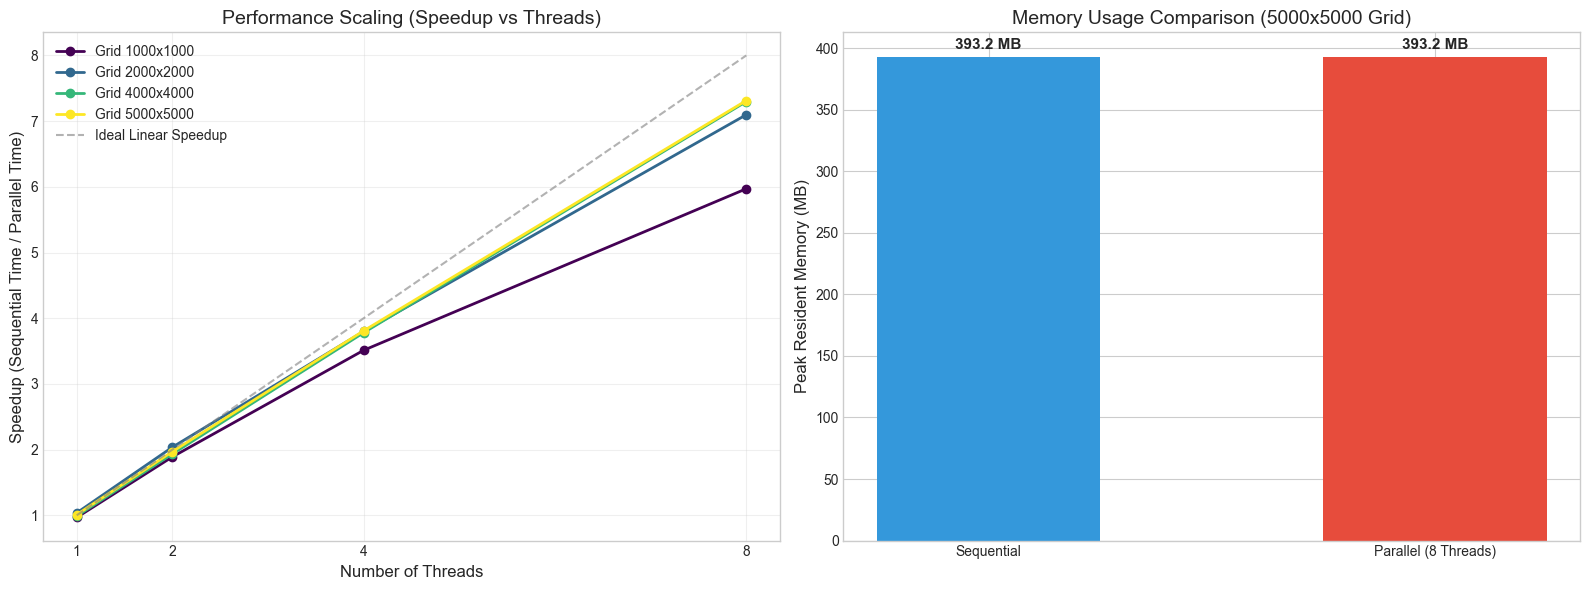

In [8]:
# --- PLOTTING RESULTS ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Filter for parallel runs
par_df = df[df["Type"] == "Parallel"]

# Plot 1: Speedup Analysis
colors = plt.cm.viridis(np.linspace(0, 1, len(GRID_SIZES)))

for i, size in enumerate(GRID_SIZES):
    subset = par_df[par_df["Size"] == size]
    ax1.plot(subset["Threads"], subset["Speedup"], 
             marker='o', linewidth=2, label=f"Grid {size}x{size}", color=colors[i])

# Add Ideal Speedup Line
ax1.plot(THREAD_COUNTS, THREAD_COUNTS, '--', color='gray', alpha=0.6, label="Ideal Linear Speedup")

ax1.set_title("Performance Scaling (Speedup vs Threads)", fontsize=14)
ax1.set_xlabel("Number of Threads", fontsize=12)
ax1.set_ylabel("Speedup (Sequential Time / Parallel Time)", fontsize=12)
ax1.set_xticks(THREAD_COUNTS)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Memory Overhead Analysis
# Compare Sequential vs Parallel (8 threads) for the largest grid size
largest_size = max(GRID_SIZES)
mem_seq = df[(df["Size"] == largest_size) & (df["Type"] == "Sequential")]["Memory_MB"].values[0]
mem_par = df[(df["Size"] == largest_size) & (df["Threads"] == 8)]["Memory_MB"].values[0]

labels = ['Sequential', 'Parallel (8 Threads)']
values = [mem_seq, mem_par]
bar_colors = ['#3498db', '#e74c3c']

bars = ax2.bar(labels, values, color=bar_colors, width=0.5)

ax2.set_title(f"Memory Usage Comparison ({largest_size}x{largest_size} Grid)", fontsize=14)
ax2.set_ylabel("Peak Resident Memory (MB)", fontsize=12)

# Add labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01*height,
             f'{height:.1f} MB',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 📊 Benchmark Summary Table

In [9]:
# Display a clean summary table sorted by Size and Efficiency
summary = df[['Size', 'Type', 'Threads', 'Time', 'Speedup', 'Memory_MB']].sort_values(['Size', 'Threads'])
summary.style.background_gradient(subset=['Speedup'], cmap='Greens').format({
    'Time': '{:.4f}',
    'Speedup': '{:.2f}',
    'Memory_MB': '{:.1f}'
})

,Size,Type,Threads,Time,Speedup,Memory_MB
0,1000,Sequential,1,4.4958,1.00,149.5
1,1000,Parallel,1,4.6492,0.97,149.5
2,1000,Parallel,2,2.3792,1.89,149.5
3,1000,Parallel,4,1.2800,3.51,149.5
4,1000,Parallel,8,0.7530,5.97,149.5
5,2000,Sequential,1,18.0787,1.00,176.6
6,2000,Parallel,1,17.4321,1.04,176.6
7,2000,Parallel,2,8.8742,2.04,176.6
8,2000,Parallel,4,4.7588,3.80,176.6
9,2000,Parallel,8,2.5473,7.10,176.6
